## Experiments

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
import time

import sys
sys.path.append('..')
from core import samplers, utility
from core.distributions import IsingModel2D
from core.dHMC import DHMCSampler, f, f_update

In [3]:
h,w = 28,28
n_samples = 1000
batch_size = 15

checkboard = np.tile(np.arange(w) % 2, [h,1])
checkboard[::2] += 1
checkboard[::2] %= 2
checkboard = checkboard.flatten()
boardcheck = (checkboard + 1) % 2

target = IsingModel2D(h,w)
initial_states = (np.random.uniform(size=[batch_size, h, w]) > 0.5).astype(np.int)

primes = utility.generate_primes(100000)
gibbs_d = samplers.DGibbs(target, v_coeffs=np.sqrt(primes)[:h*w])
suzuki = samplers.DGibbs(target)
gibbs = samplers.Gibbs(target)

In [4]:
def run_chain(sampler, state0):
    sampler.initialize(state0)    
    x, weights = np.zeros([n_samples, h*w]), np.zeros([n_samples, 1])
    start = time.time()
    for x_id in range(n_samples):
        x[x_id], weights[x_id] = sampler.iterate_n(h*w)
    return x, weights, time.time() - start

def run_experiment(sampler, initial_states, sampler_name, exp_name):
    errors_exp = np.zeros([batch_size, n_samples])
    log_p_exp = np.zeros([batch_size, n_samples])
    times = np.zeros(batch_size)
    for exp_id in range(batch_size):
        x,weights,time_elapsed = run_chain(sampler, initial_states[exp_id])
        times[exp_id] = time_elapsed
        
        mode = checkboard
        last_mean = np.sum(x[-(n_samples//10):]*weights[-(n_samples//10):], axis=0)
        last_mean /= np.sum(weights[-(n_samples//10):], axis=0)
        if np.mean(np.abs(last_mean-boardcheck)) < np.mean(np.abs(last_mean-checkboard)):
            mode = boardcheck
        means = np.cumsum(x*weights, axis=0)/np.cumsum(weights, axis=0)
        errors_exp[exp_id] = np.sum(np.abs(means-mode), axis=1)
        for sample_id in range(n_samples):
            log_p_exp[exp_id, sample_id] = target.get_log_prob(x[sample_id].reshape([h,w]))
    results = {'n_samples': n_samples,
               'errors': errors_exp,
               'log_p': log_p_exp,
               'times': times,
               'initial_states': initial_states}
    name = '{}_{}_{}'.format(exp_name, sampler_name, ':'.join(map(lambda s: str(s), [*time.localtime()])))
    with open('../results/ising/{}.pickle'.format(name), 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def run_dHMC_experiment(initial_states, exp_name):
    errors_exp = np.zeros([batch_size, n_samples])
    log_p_exp = np.zeros([batch_size, n_samples])
    times = np.zeros(batch_size)
    for exp_id in range(batch_size):
        dhmc = DHMCSampler(f, f_update, h*w, h*w)
        dt = 0.9 * np.array([.8, 1])
        nstep = [1, 2]
        theta0 = initial_states[exp_id].flatten().astype(np.float)
        x, logp_samples, time_elapsed = dhmc.run_sampler(theta0, dt, nstep, 
                                                         n_burnin=0, n_sample=n_samples, 
                                                         seed=1, n_update=1)
        x = np.floor(x)
        weights = np.ones([n_samples,1])
        times[exp_id] = time_elapsed
        
        mode = checkboard
        last_mean = np.sum(x[-(n_samples//10):]*weights[-(n_samples//10):], axis=0)
        last_mean /= np.sum(weights[-(n_samples//10):], axis=0)
        if np.mean(np.abs(last_mean-boardcheck)) < np.mean(np.abs(last_mean-checkboard)):
            mode = boardcheck
        means = np.cumsum(x*weights, axis=0)/np.cumsum(weights, axis=0)
        errors_exp[exp_id] = np.sum(np.abs(means-mode), axis=1)
        for sample_id in range(n_samples):
            log_p_exp[exp_id, sample_id] = target.get_log_prob(x[sample_id].reshape([h,w]))
    results = {'n_samples': n_samples,
               'errors': errors_exp,
               'log_p': log_p_exp,
               'times': times,
               'initial_states': initial_states}
    name = '{}_{}_{}'.format(exp_name, 'dHMC', ':'.join(map(lambda s: str(s), [*time.localtime()])))
    with open('../results/ising/{}.pickle'.format(name), 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
run_experiment(gibbs_d, initial_states, 'DGibbs', 'Ising2D')
run_experiment(gibbs, initial_states, 'Gibbs', 'Ising2D')
run_dHMC_experiment(initial_states, 'Ising2D')

1000 iterations have been completed.
1000 iterations have been completed.
1000 iterations have been completed.
1000 iterations have been completed.
1000 iterations have been completed.
1000 iterations have been completed.
1000 iterations have been completed.
1000 iterations have been completed.
1000 iterations have been completed.
1000 iterations have been completed.
1000 iterations have been completed.
1000 iterations have been completed.
1000 iterations have been completed.
1000 iterations have been completed.
1000 iterations have been completed.


## Results

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
import time

import sys
sys.path.append('..')

In [3]:
!ls ../results/ising/

Ising2D_DGibbs_2021:2:3:0:44:39:2:34:0.pickle
Ising2D_dHMC_2021:2:3:1:13:43:2:34:0.pickle
Ising2D_Gibbs_2021:2:3:1:1:19:2:34:0.pickle


In [4]:
with open('../results/ising/Ising2D_Gibbs_2021:2:3:1:1:19:2:34:0.pickle', 'rb') as handle:
    results_gibbs = pickle.load(handle)
with open('../results/ising/Ising2D_DGibbs_2021:2:3:0:44:39:2:34:0.pickle', 'rb') as handle:
    results_d = pickle.load(handle)
with open('../results/ising/Ising2D_dHMC_2021:2:3:1:13:43:2:34:0.pickle', 'rb') as handle:
    results_dHMC = pickle.load(handle)

In [6]:
def filter_convergence_to_other_mode(results):
    ids = np.argsort(results['errors'][:,-1])
    results['errors'] = results['errors'][ids[:10],:]
    results['log_p'] = results['log_p'][ids[:10],:]
    results['times'] = results['times'][ids[:10]]
    results['initial_states'] = results['initial_states'][ids[:10],:,:]

In [7]:
filter_convergence_to_other_mode(results_gibbs)
filter_convergence_to_other_mode(results_d)
filter_convergence_to_other_mode(results_dHMC)

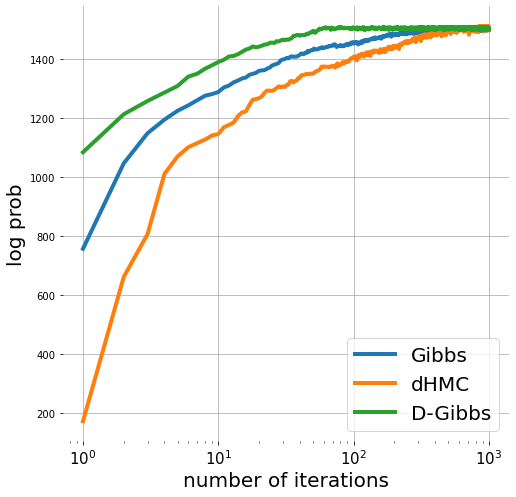

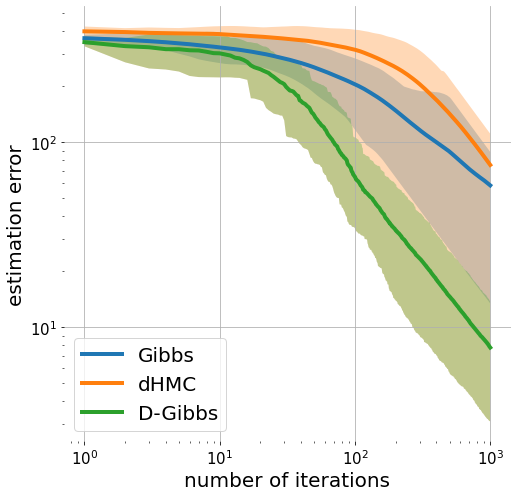

In [21]:
num_samples = np.arange(1,results_d['n_samples']+1)

figsize(8,8)
plt.plot(num_samples, np.mean(results_gibbs['log_p'],axis=0), label='Gibbs', lw=4)
plt.plot(num_samples, np.mean(results_dHMC['log_p'],axis=0), label='dHMC', lw=4)
plt.plot(num_samples, np.mean(results_d['log_p'],axis=0), label='D-Gibbs', lw=4)
plt.ylabel('log prob', fontsize=20)
plt.xlabel('number of iterations', fontsize=20)
plt.xscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=10)
plt.box(False)
plt.legend(fontsize=20)
plt.grid()
plt.savefig('../results/log_prob_ising.pdf', bbox_inches='tight')
plt.show()

plt.plot(num_samples, np.mean(results_gibbs['errors'],axis=0), label='Gibbs', lw=4)
plt.fill_between(num_samples, np.sort(results_gibbs['errors'],axis=0)[1,:], 
                     np.sort(results_gibbs['errors'],axis=0)[-2,:], alpha=0.3)
plt.plot(num_samples, np.mean(results_dHMC['errors'],axis=0), label='dHMC', lw=4)
plt.fill_between(num_samples, np.sort(results_dHMC['errors'],axis=0)[1,:], 
                     np.sort(results_dHMC['errors'],axis=0)[-2,:], alpha=0.3)
plt.plot(num_samples, np.mean(results_d['errors'],axis=0), label='D-Gibbs', lw=4)
plt.fill_between(num_samples, np.sort(results_d['errors'],axis=0)[1,:], 
                     np.sort(results_d['errors'],axis=0)[-2,:], alpha=0.3)
plt.ylabel('estimation error', fontsize=20)
plt.xlabel('number of iterations', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.box(False)
plt.legend(fontsize=20)
plt.grid()
plt.savefig('../results/error_ising.pdf', bbox_inches='tight')

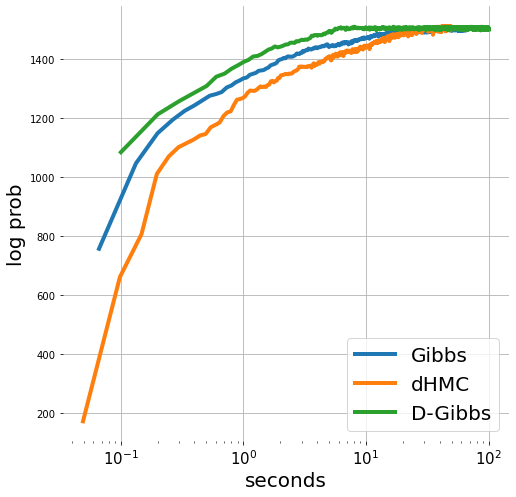

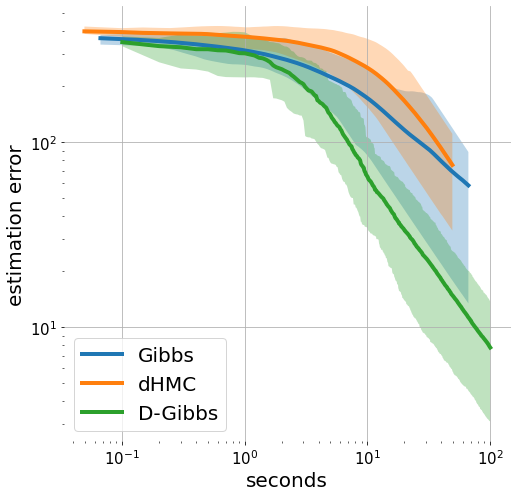

In [22]:
num_samples = np.arange(1,results_gibbs['n_samples']+1)
sps_gibbs = results_gibbs['n_samples']/np.mean(results_gibbs['times'])
sps_dHMC = results_gibbs['n_samples']/np.mean(results_dHMC['times'])
sps_d = results_gibbs['n_samples']/np.mean(results_d['times'])

figsize(8,8)
plt.plot(num_samples/sps_gibbs, np.mean(results_gibbs['log_p'],axis=0), label='Gibbs', lw=4)
plt.plot(num_samples/sps_dHMC, np.mean(results_dHMC['log_p'],axis=0), label='dHMC', lw=4)
plt.plot(num_samples/sps_d, np.mean(results_d['log_p'],axis=0), label='D-Gibbs', lw=4)
plt.ylabel('log prob', fontsize=20)
plt.xlabel('seconds', fontsize=20)
plt.xscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=10)
plt.box(False)
plt.legend(fontsize=20)
plt.grid()
plt.savefig('../results/log_prob_ising_time.pdf', bbox_inches='tight')
plt.show()

plt.plot(num_samples/sps_gibbs, np.mean(results_gibbs['errors'],axis=0), label='Gibbs', lw=4)
plt.fill_between(num_samples/sps_gibbs, np.sort(results_gibbs['errors'],axis=0)[1,:], 
                     np.sort(results_gibbs['errors'],axis=0)[-2,:], alpha=0.3)
plt.plot(num_samples/sps_dHMC, np.mean(results_dHMC['errors'],axis=0), label='dHMC', lw=4)
plt.fill_between(num_samples/sps_dHMC, np.sort(results_dHMC['errors'],axis=0)[1,:], 
                     np.sort(results_dHMC['errors'],axis=0)[-2,:], alpha=0.3)
plt.plot(num_samples/sps_d, np.mean(results_d['errors'],axis=0), label='D-Gibbs', lw=4)
plt.fill_between(num_samples/sps_d, np.sort(results_d['errors'],axis=0)[1,:], 
                     np.sort(results_d['errors'],axis=0)[-2,:], alpha=0.3)
plt.ylabel('estimation error', fontsize=20)
plt.xlabel('seconds', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.box(False)
plt.legend(fontsize=20)
plt.grid()
plt.savefig('../results/error_ising_time.pdf', bbox_inches='tight')